##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Credit Cards

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1uycKZCjyskYCXF2DbVOJd77BALOlMMSt"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>
<br>
<br>
<br>

### Dependencies & Prerequisites

In [0]:
#@title Tensorflow Probability Installation settings { display-mode: "form" }
TFP_Installation = "Most Recent TFP" #@param ["Most Recent TFP", "Stable TFP", "Stable TFP-GPU", "Most Recent TFP-GPU", "TFP Already Installed"]

if TFP_Installation == "Most Recent TFP":
    !pip3 install -q tfp-nightly
    print("Most recent TFP version installed")
elif TFP_Installation == "Stable TFP":
    !pip3 install -q --upgrade tensorflow-probability
    print("Up-to-date, stable  TFP version installed")
elif TFP_Installation == "Stable TFP-GPU":
    !pip3 install -q --upgrade tensorflow-probability-gpu
    print("Up-to-date, stable TFP-GPU version installed")
    print("(make sure GPU is properly configured)")
elif TFP_Installation == "Most Recent TFP-GPU":
    !pip3 install -q tfp-nightly-gpu
    print("Most recent TFP-GPU version installed")
    print("(make sure GPU is properly configured)")
elif TFP_Installation == "TFP Already Installed":
    print("TFP already instaled in this environment")
    pass
else:
    print("Installation Error: Please select a viable TFP installation option.")



Most recent TFP version installed


In [0]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
     return tf.contrib.framework.nest.pack_sequence_as(
       tensors,
       [t.numpy() if tf.contrib.framework.is_tensor(t) else t
       for t in tf.contrib.framework.nest.flatten(tensors)])
  with tf.Session() as sess:
    return sess.run(tensors)


class _TFColor(object):
  """Enum of colors used in TF docs."""
  red = '#F15854'
  blue = '#5DA5DA'
  orange = '#FAA43A'
  green = '#60BD68'
  def __getitem__(self, i):
    return [
        self.red,
        self.orange,
        self.green,
        self.blue,
    ][i % 4]
TFColor = _TFColor()

Let’s imagine that you would like to estimate the interest rate on your credit card one year from now. Suppose the current prime rate is 2% and your credit card company charges you 10% plus prime. Given the strength of the current economy, you believe that the Federal Reserve is more likely to raise interest rates than not. The Fed will meet eight times in the next twelve months and will either raise the federal funds rate by 0.25% or leave it at the previous level. 

We use the binomial distribution to model your credit card’s interest rate at the end of the twelve-month period. Specifically, we’ll use the TensorFlow Probability Binomial distribution class  with the following parameters: total_count = 8 (number of trials or meetings), probs = {.6, .7, .8, .9}, for our range of estimates about the probability of the Fed raising the federal funds rate by 0.25% at each meeting.


### Compute Probabilities

Compute the probabilities of possible credit card interest rates in 12 months.

In [0]:
# First we encode our assumptions.
cc_interest_rates_range = 12. + 0.25 * tf.range(start=0.,  limit=16.)
cc_interest_rate =tf.range(start=0.,  limit=16.)
prob_fed_raises_rates = tf.constant([0.6, 0.7, 0.8, 0.9])
num_times_fed_meets_per_year = 8.

# Now we use TFP to compute probabilities in a vectorized manner.
# Pad a dim so we broadcast fed probs against CC interest rates.
prob_fed_raises_rates = prob_fed_raises_rates[..., tf.newaxis]
prob_cc_interest_rate = tfd.Binomial(
    total_count=num_times_fed_meets_per_year,
    probs=prob_fed_raises_rates).prob(cc_interest_rate)

### Execute TF Code

In [0]:
# Convert from TF to numpy.
[
    prob_fed_raises_rates_,
    cc_interest_rate_,
    prob_cc_interest_rate_,
    cc_interest_rates_range_,
] = evaluate([
    prob_fed_raises_rates,
    cc_interest_rate,
    prob_cc_interest_rate,
    cc_interest_rates_range,
])

### Visualize Results

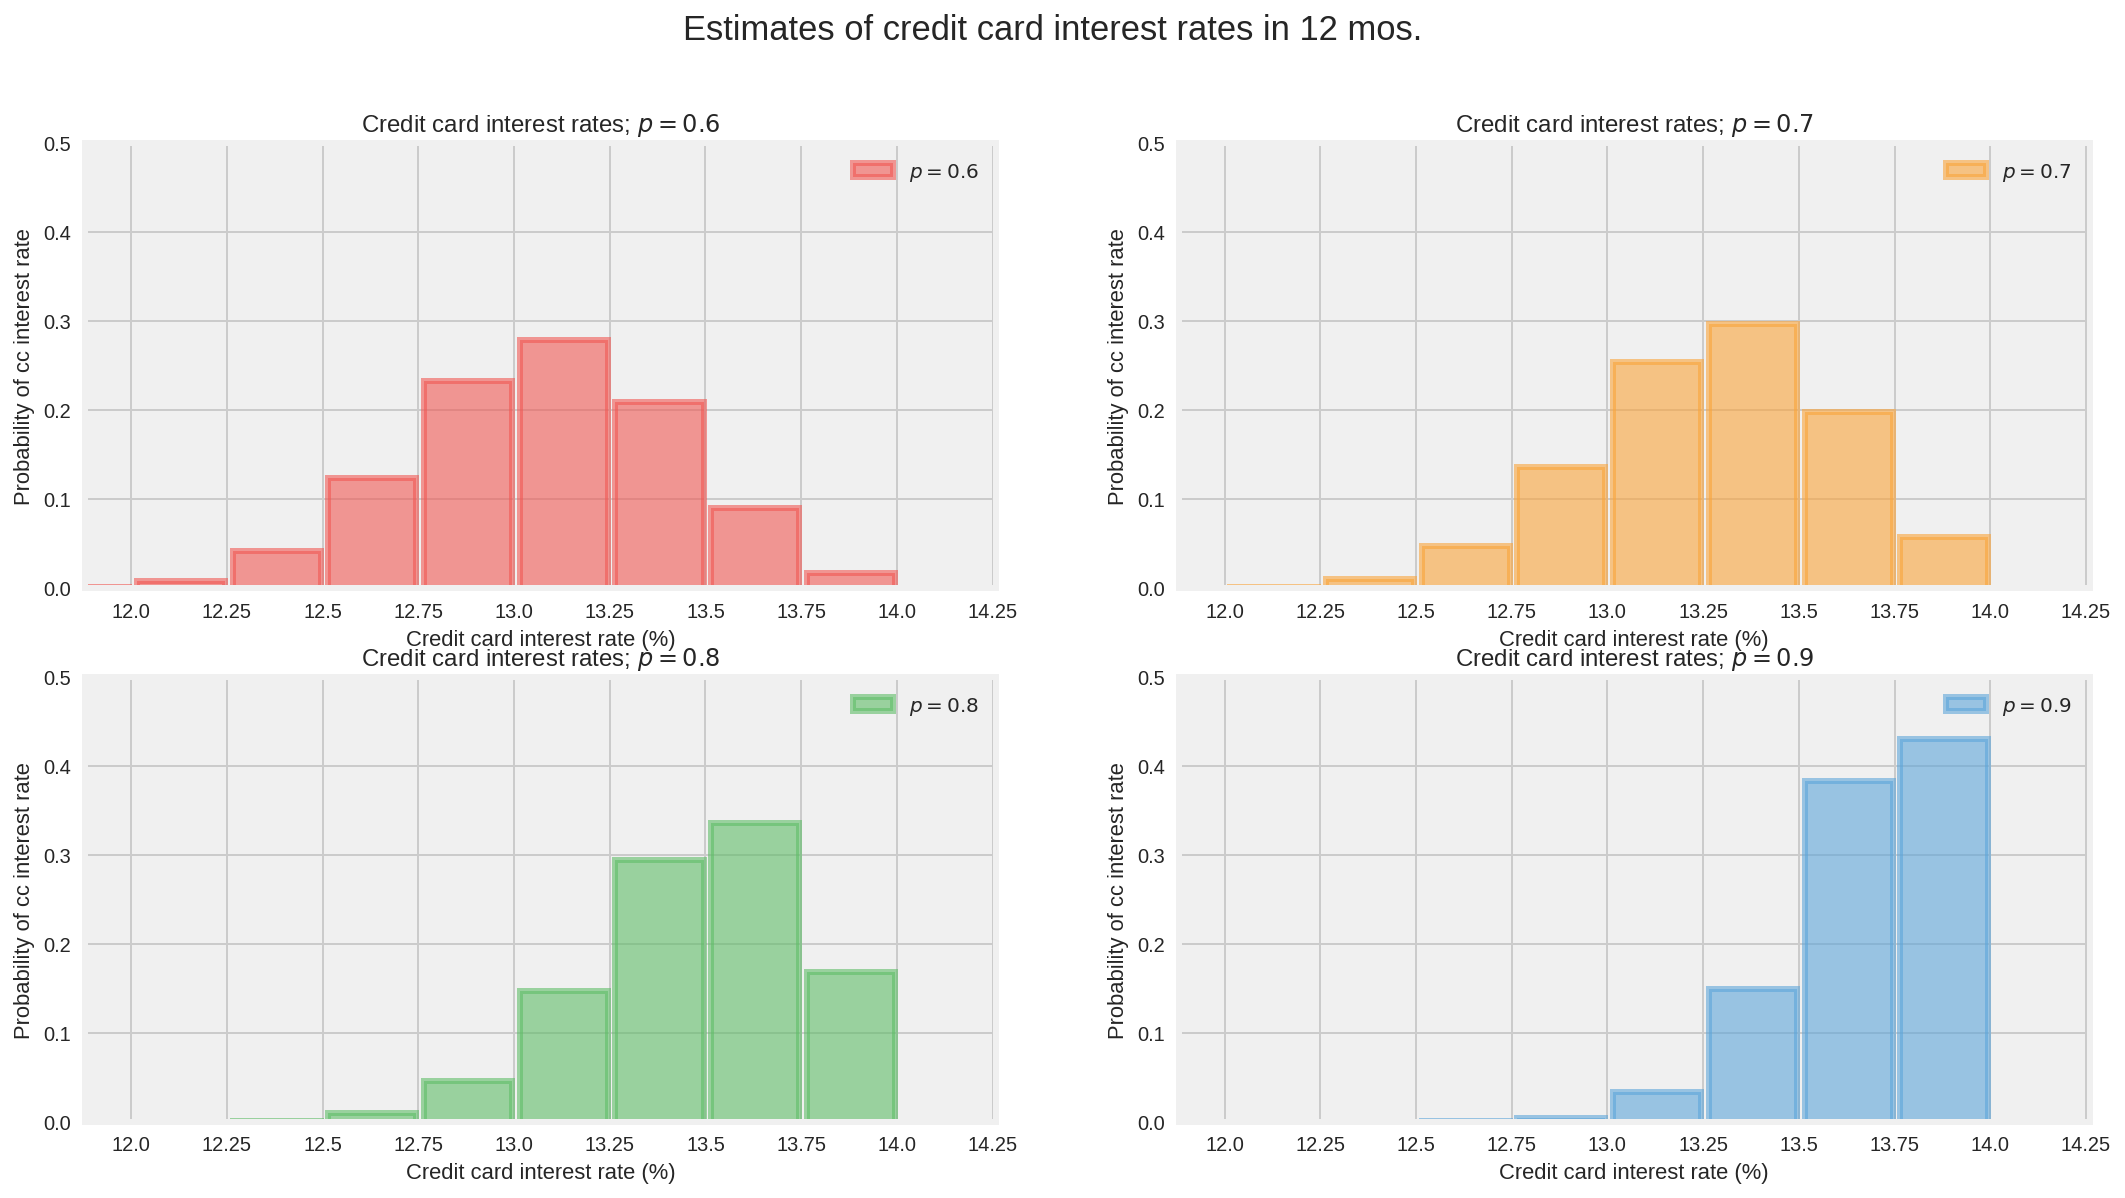

In [0]:
figsize(16, 9)
for i, pf in enumerate(prob_fed_raises_rates_):
    plt.subplot(2, 2, i+1)
    plt.bar(cc_interest_rates_range_,
            prob_cc_interest_rate_[i],
            color=TFColor[i],
            width=0.23,
            label="$p = %.1f$" % pf, alpha=0.60,
            edgecolor=TFColor[i], lw="3")
    plt.xticks(cc_interest_rates_range_ + 0.12, cc_interest_rates_range_)
    plt.xlim(12, 14.38);
    plt.ylim(0, 0.5);
    plt.legend()
    plt.ylabel("Probability of cc interest rate")
    plt.xlabel("Credit card interest rate (%)")
    plt.title("Credit card interest rates; $p = %.1f$" % pf);
    plt.suptitle("Estimates of credit card interest rates in 12 mos.",
                 fontsize="x-large")